In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata

## Cumulative Distribution
$\tau$ is current time, $t$ is time step (delta_t)
$$ F_{\tau}(t) = 1 - \exp \Big\{ - \int_{\tau}^{\tau+t} \lambda(s) {d}s \Big\} $$

draw $t \sim f_{\tau}(t) = \frac{\partial}{\partial t} (F_{\tau} (t) ) $

Inverse transformation sampling --> draw uniform number $u \in [0,1]$ and find inverse CDF $F_{\tau}^{-1}(u) = T $--> returns the largest $t$ from the domain of the PDF such that $\mathbb{P}(-\infty < T < t) \leq u$

Specifically, if $u$ has a uniform distribution on $[0,1]$ and if $T$ has a cumulative distribution $F_{\tau}$ then the random variable $F_{\tau}^{-1}(u)$ has the same distribution as $T$. 

In [6]:
def CDF(max_time, dt, tau, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, Input, B ):
    N = sum(Input)
    tt = np.arange(0,max_time, dt)    
    
    mt = (sigma*Input[1] + (omega+mort*mu1)*Input[2] +
         (mort*mu2 + (1-mort)*mu2)*Input[3] + 
         (beta/N)*Input[0]*(Input[2]+alpha*Input[3]))*tt - (1/B)*epsilon_vector(B,tt,tau, epsilon)*Input[0]
    
    F = 1 - np.exp(-mt)
    return tt, F, mt
    

In [7]:
def epsilon_vector(bb, tt, tau, e):
    eps = np.zeros(len(tt))
    y = np.where(np.sin(bb*(tt))>=0)
    y = np.array(y)[0]
    eps[y] = ([(e/bb)*(np.cos(bb*(tt[i]+tau))-np.cos(bb*tau)) for i in y])
    return eps

In [8]:
def epsilon_scalar(bb, tt, tau, e):
    eps = 0
    if np.sin(bb*tt)>=0:
        eps = (e/bb)*(np.cos(bb*(tt+tau))-np.cos(bb*tau))

    return eps

In [9]:
def inverseCDF(t, F):
    r = np.random.uniform(0,1)
    s2 = np.min(np.where(F>r))
    s1 = s2-1
    
    y2,y1 = F[s2], F[s1]
    x2, x1 = t[s2], t[s1]
    
    m = (y2-y1)/(x2-x1)
    tt = (r-y1)/m + x1
    return tt

# Example of inversing CDF

In [10]:
cdf_rate = CDF(1000, 0.01,0, 1.3, 1/7, 1/5, 1/5, 1/12, 0.001, 1, 0.7, [1500,1,0,0], 2*np.pi/365)

In [11]:
tt = np.arange(0,10, 0.001)

In [12]:
time_steps = []
for l in range(10000):
    time_steps.append(inverseCDF(cdf_rate[0], cdf_rate[1]))

Text(0.5,0,'Δt')

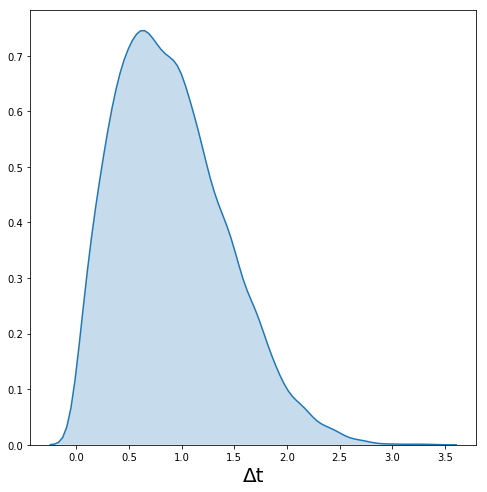

In [17]:
plt.figure(figsize = (8,8))
sns.kdeplot(time_steps, shade = True)
plt.xlabel('Δt', fontsize = 20)

# Adaptive Gillespie for non constant external infection $ɛ(t)$

### Parameters

In [18]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 150
γ = 1/(80*365)
period = (2*np.pi)/365
Input_H = [1500,1,0,0,0]
Nn = sum(Input_H)

In [19]:
def changingGillespie(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, B,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time :
        state = np.zeros(shape= (5,12))
        ####################################################################################
        ##################################### TIME #########################################
        ####################################################################################
        Cdensity = CDF(100, 0.01, times, beta, mu1,mu2, sigma, 
                       omega,epsilon,alpha, mort, pop[ind], B)
        
        delta_t = inverseCDF(Cdensity[0], Cdensity[1])
        
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = (delta_t*beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N - 
                pop[ind][0]*epsilon_scalar(B, times, delta_t,epsilon))
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = delta_t*sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = delta_t*omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = delta_t*mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = delta_t*mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = delta_t*(1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = delta_t*(1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]

        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)

        P = np.random.uniform(0,1)*Rtotal

        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
        else:
            times =times+ delta_t
            events.append(-1)
            event_append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind])
        else:
            cuminf.append(0 + cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events, cuminf

In [21]:
cG = changingGillespie(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, period, capT)
SEIHRt = cG[0]
SEIHRs = cG[1][:,0]
SEIHRe = cG[1][:,1]
SEIHRi = cG[1][:,2]
SEIHRh = cG[1][:,3]
SEIHRr = cG[1][:,4]

In [22]:
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt):
    if ind<len(SEIHRt)-1:
        manhe.append((SEIHRe[ind], SEIHRe[ind]))
        manhh.append((SEIHRh[ind], SEIHRh[ind]))
        manhi.append((SEIHRi[ind], SEIHRi[ind]))
        manht.append((SEIHRt[ind], SEIHRt[ind+1]))
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

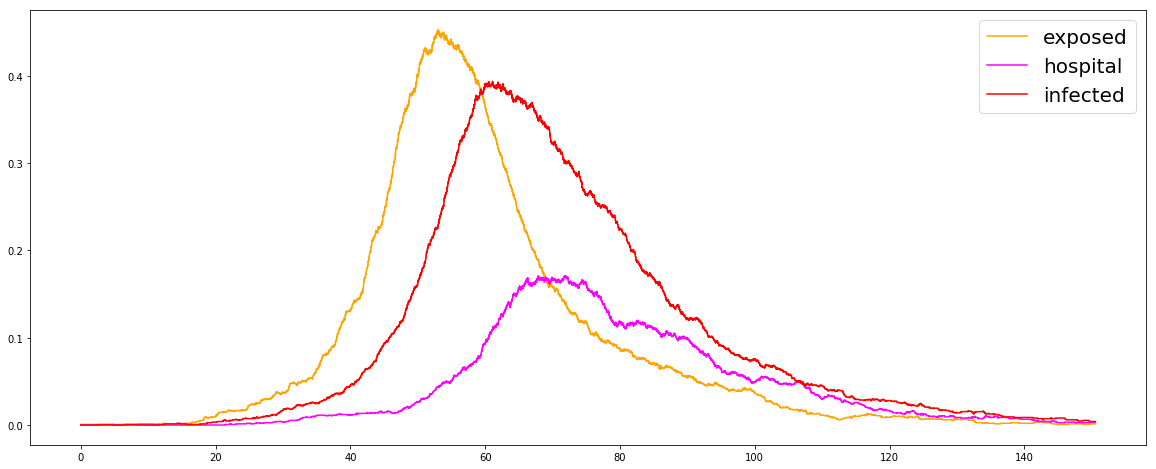

In [24]:
plt.figure(figsize = (20,8))
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hospital')

plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)
